# Low-Rank Optimal Transport through Factor Relaxation with Latent Coupling


In [72]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt


from ott.geometry import geometry
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, sinkhorn_lr
from ott.tools import plot

from ott.initializers.linear.initializers_lr import KMeansInitializer

# from numba import jit


In [73]:
def create_points(rng, n, m, d):
    rngs = jax.random.split(rng,4)
    x = jax.random.normal(rngs[0], (n, d)) + 1
    y = jax.random.uniform(rngs[1], (m, d))
    a = jax.random.uniform(rngs[2], (n,))
    b = jax.random.uniform(rngs[3], (m,))
    a = a / jnp.sum(a)
    b = b / jnp.sum(b)
    return x, y, a, b


In [ ]:
rng = jax.random.key(0)
n, m, d = 19, 35, 2
x, y, a, b = create_points(rng, n=n, m=m, d=d)

geom = pointcloud.PointCloud(x, y, epsilon=0.1)
prob = linear_problem.LinearProblem(geom, a=a, b=b)

C = geom.cost_matrix

r = 5
gamma=10
epsilon=1e-3

tau = 1.
delta = 1.
max_iter = 30


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot for x and y with color mapping
scatter_x = ax.scatter(x[:, 0], x[:, 1], c=a, cmap="Blues", label="x", marker="x")
scatter_y = ax.scatter(y[:, 0], y[:, 1], c=b, cmap="Reds", label="y", marker="s")

# Add colorbars for each scatter plot
cbar_x = plt.colorbar(scatter_x, ax=ax, label="Weights for x (a)", orientation="vertical")
cbar_y = plt.colorbar(scatter_y, ax=ax, label="Weights for y (b)", orientation="vertical")

# Add labels and legend
plt.legend()
plt.title("Scatter plot of x and y with weights")
plt.show()


In [75]:

def initialize_couplings(rng, a, b, gQ, gR, r):
    #algo 6

    rngs = jax.random.split(rng,3)
    n, m = a.shape[0], b.shape[0]
    CQ = jax.random.uniform(key=rngs[0], shape=(n, r))
    CR = jax.random.uniform(key=rngs[1], shape=(m, r))
    CT = jax.random.uniform(key=rngs[2], shape=(r, r))
    
    KQ, KR, KT = jax.numpy.exp(CQ), jax.numpy.exp(CR), jax.numpy.exp(CT)
    
    geomQ = geometry.Geometry(cost_matrix=KQ)
    geomR = geometry.Geometry(cost_matrix=KR)
    geomT = geometry.Geometry(cost_matrix=KT)
    
    solver = sinkhorn.Sinkhorn() 
    
    ot_probQ = linear_problem.LinearProblem(geomQ, a, gQ)
    ot_probR = linear_problem.LinearProblem(geomR, b, gQ)

    ot_sinkQ = solver(ot_probQ)
    ot_sinkR = solver(ot_probR)
    

    gQ = jnp.dot(ot_sinkQ.matrix.T, jnp.ones(shape=(n,)))
    gR = jnp.dot(ot_sinkR.matrix.T, jnp.ones(shape=(m,)))
    
    ot_probT = linear_problem.LinearProblem(geomT, gQ, gR)
    ot_sinkT = solver(ot_probT)
    
    return ot_sinkQ.matrix, ot_sinkR.matrix, ot_sinkT.matrix


In [76]:

def delta_diff(x_k, x_k1, gamma_k):
    """Computes the delta criterion defined in (10).

    Args:
        x_k (tuple): (Q_k, R_k, T_k)
        x_k1 (tuple): (Q_k+1, R_k+1, T_k+1)
    """
    
    Q_k, R_k, T_k = x_k
    Q_k1, R_k1, T_k1 = x_k1
    
    Q_diff = jnp.linalg.norm(Q_k1-Q_k, ord='fro')**2
    R_diff = jnp.linalg.norm(R_k1-R_k, ord='fro')**2
    T_diff = jnp.linalg.norm(T_k1-T_k, ord='fro')**2
    
    return (1/gamma_k**2) *(Q_diff + R_diff + T_diff)

def compute_grad(C, Q, R, X, gQ, gR):
    n, m = Q.shape[0], R.shape[0]
    
    gradQ = (C @ R) @ X.T
    w1 = jnp.diag((gradQ.T @ Q) @ jnp.diag(1/gQ))
    gradQ -= jnp.outer(jnp.ones((n,)), w1)
    
    gradR = (C.T @ Q) @ X
    w2 = jnp.diag( jnp.diag(1/gR) @ (R.T @ gradR) )
    gradR -= jnp.outer(jnp.ones((m,)), w2)
    
    return gradQ, gradR
    

def semi_relaxed_projection(K, gamma, tau, a, b, delta):
    n, r = K.shape
    u = jnp.ones((n,))
    v = jnp.ones((r,))
    power = tau/(tau+1/delta)
    
    while True:
        u_tild = u
        v_tild = v
        u = a / (K@v)
        v = (b / (K.T@u))**power
        if 1/gamma *jnp.max(jnp.array([jnp.max(jnp.abs(jnp.log(u_tild)/u)), jnp.max(jnp.abs(jnp.log(v_tild)/v))])) < delta:
            break
    return jnp.diag(u) @ K @ jnp.diag(v)
    

In [ ]:

def balanced_frlc(rng, C, r, a, b, tau, gamma, delta, epsilon, max_iter):
    # Algorithm 1
    n, m = a.shape[0], b.shape[0]
    gQ = 1/r*jnp.ones(shape=(r,))
    gR = 1/r*jnp.ones(shape=(r,))
    Q0, R0, T0 = initialize_couplings(rng, a, b, gQ, gR, r)
    
    X0_l = jnp.diag(1/(jnp.dot(Q0.T, jnp.ones(shape=(n,)))))
    X0_r = jnp.diag(1/(jnp.dot(R0.T, jnp.ones(shape=(m,)))))
    X0 = X0_l @ T0 @ X0_r
    
    Qk_prev, Rk_prev, Tk_prev = jnp.zeros_like(Q0), jnp.zeros_like(R0), jnp.zeros_like(T0)
    Qk, Rk, Tk, Xk = Q0, R0, T0, X0
    gamma_k = gamma
    
    k = 0
    while (delta_diff((Qk, Rk, Tk), (Qk_prev, Rk_prev, Tk_prev), gamma_k) > epsilon) and k < max_iter:
        Qk_prev, Rk_prev, Tk_prev = Qk, Rk, Tk
        
        gradQ, gradR = compute_grad(C, Qk, Rk, Xk, gQ, gR)
        gamma_k /= jnp.max(jnp.array([jnp.max(jnp.abs(gradQ)) , jnp.max(jnp.abs(gradR))]))
        
        KQ = Qk * jnp.exp(-gamma_k * gradQ)
        KR = Rk * jnp.exp(-gamma_k * gradR) # computation : use a log version ?
        
        Qk = semi_relaxed_projection(KQ, gamma_k, tau, a, Qk_prev.T@jnp.ones((n,)), delta)
        Rk = semi_relaxed_projection(KR, gamma_k, tau, b, Rk_prev.T@jnp.ones((m,)), delta)
        
        gQ, gR = Qk.T @ jnp.ones((n,)), Rk.T @ jnp.ones((m,))
        gradT = jnp.diag(1/gQ) @ Qk.T @ C @ Rk @ jnp.diag(1/gR)
        gamma_T = gamma / jnp.max(jnp.abs(gradT))
         
        KT = Tk * jnp.exp(-gamma_T*gradT)
        
        geomT = geometry.Geometry(cost_matrix=KT)
        probT = linear_problem.LinearProblem(geomT, gR, gQ)
        solver = sinkhorn.Sinkhorn() 

        Tk = solver(probT).matrix
        Xk = jnp.diag(1/gQ) @ Tk @ jnp.diag(1/gR)
                
        k += 1

    return Qk @ Xk @ Rk.T
        
        
    

In [ ]:
P = balanced_frlc(rng, C, r, a, b, tau, gamma, delta, epsilon, max_iter)

class ManualTransport: #just to use the plot from the ott lib
    def __init__(self, matrix, problem, geom, a, b):
        self.matrix = matrix
        self.problem = problem
        self.geom = geom
        self.a = a
        self.b = b

    @property
    def cost(self):
        return jnp.sum(self.matrix * self.problem.geom.cost_matrix)

T = ManualTransport(P, prob, geom, a, b)


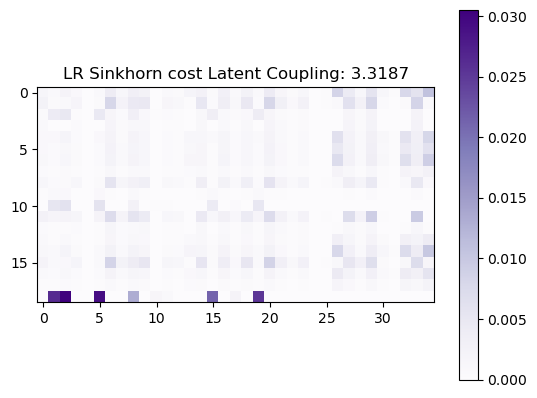

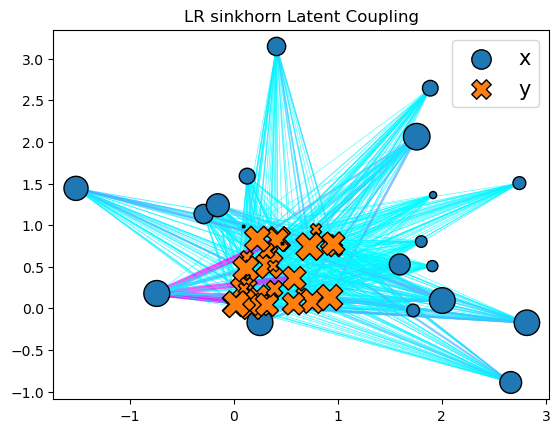

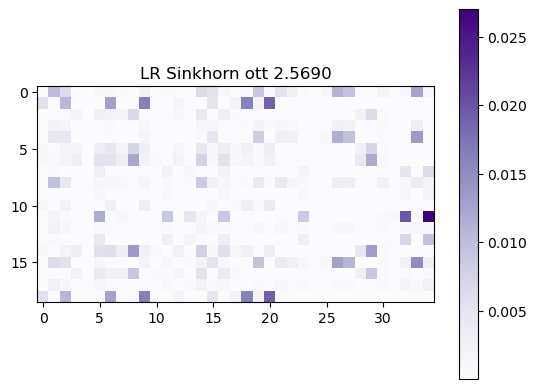

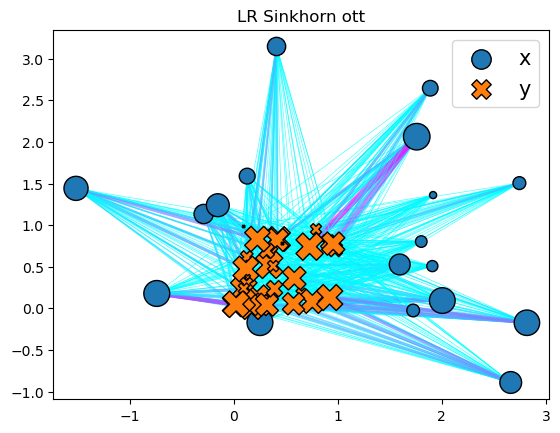

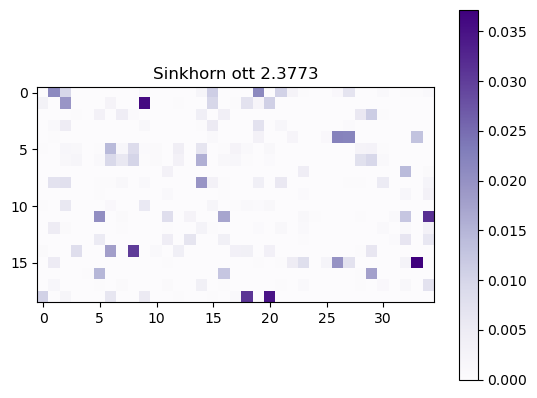

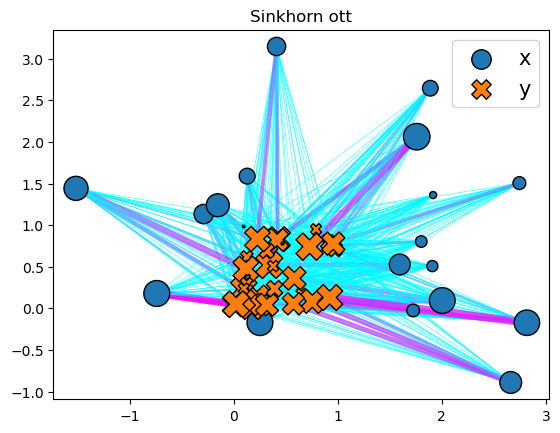

In [ ]:


plt.imshow(T.matrix, cmap="Purples")
plt.title(f"LR Sinkhorn cost Latent Coupling: {T.cost:.4f}")
plt.colorbar()
plt.show()

plott = plot.Plot(title="LR sinkhorn Latent Coupling")
_ = plott(T)
plt.show()

solver_lr = jax.jit(sinkhorn_lr.LRSinkhorn(rank=r, initializer=KMeansInitializer(rank=r)))
ot_sink_lr = solver_lr(prob)
plt.imshow(ot_sink_lr.matrix, cmap="Purples")
plt.title(f"LR Sinkhorn ott {ot_sink_lr.primal_cost:.4f}")
plt.colorbar()
plt.show()

plott = plot.Plot(title="LR Sinkhorn ott")
_ = plott(ot_sink_lr)
plt.show()

solver = jax.jit(sinkhorn.Sinkhorn())
ot_sink = solver(prob)
plt.imshow(ot_sink.matrix, cmap="Purples")
plt.title(f"Sinkhorn ott {ot_sink.primal_cost:.4f}")
plt.colorbar()
plt.show()

plott = plot.Plot(title="Sinkhorn ott")
_ = plott(ot_sink)
plt.show()



